In [38]:
import cv2
import os
import pickle
import numpy as np

from PIL import Image, ImageChops
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten
import tensorflow as tf

In [2]:
folder_path_authentic = "data\\test\\authentic"
folder_path_copy = "data\\test\\copy-moved\\images"
folder_path_spliced = "data\\test\\spliced\\images"

In [3]:
def create_dataframe(folder_path, label, ori_label):
    images = []
    labels = []
    original_labels = []
    for filename in os.listdir(folder_path):
        
        image_path = os.path.join(folder_path, filename)
        image = cv2.imread(image_path)
            
        image_width, image_height = 128, 128
        image = cv2.resize(image, (image_width, image_height))
        images.append(image)
        labels.append(label)
        original_labels.append(ori_label)
    return images, labels , original_labels


In [8]:
authentic_images, authentic_labels, auth_ori_label = create_dataframe(folder_path_authentic, 0, 0)
copy_images , copy_labels, copy_ori_label = create_dataframe(folder_path_copy, 1, 1)
sliced_images, sliced_labels, sliced_ori_label = create_dataframe(folder_path_spliced, 1, 2)

(166, 166, 166)

In [11]:

images = np.concatenate((authentic_images, copy_images, sliced_images), axis = 0)
# labels = np.concatenate((auth_ori_label,copy_labels, sliced_ori_label ), axis = 0)
labels = np.concatenate((authentic_labels,copy_ori_label, sliced_labels ), axis = 0)



In [16]:
import numpy as np

combined = list(zip(images, labels))
np.random.shuffle(combined)
shuffled_images, shuffled_labels = zip(*combined)
shuffled_images = np.array(shuffled_images)
shuffled_labels = np.array(shuffled_labels)


In [17]:


def compute_ela(image_array, quality):
    temp_path = "ela\\spliced\\temp.jpg"

    # Save the image with a specific quality to create the compressed version
    original_image = Image.fromarray(np.uint8(image_array))

    original_image.save(temp_path, "JPEG", quality=quality)

    # Open the compressed image
    compressed_image = Image.open(temp_path)

    # Compute the difference between the original and compressed images
    ela_image = ImageChops.difference(original_image, compressed_image)

    # Convert the ELA image to grayscale
    ela_image = ela_image.convert("L")

    # Remove the temporary compressed image
    os.remove(temp_path)
    ela_image = ela_image.resize((128,128))
    
    
    ela_image_3d = Image.new("RGB", ela_image.size)
    ela_image_3d.paste(ela_image, (0, 0))

    return np.array(ela_image_3d)

In [20]:
ela_images = []
for image in shuffled_images:
    ela_image = compute_ela(image, 90)
    ela_images.append(ela_image)

In [34]:
with open('model_resnet101.pkl', 'rb') as file:
    model_resnet101_wts = pickle.load(file)

In [35]:

with open('model_resnet50.pkl', 'rb') as file:
    model_resnet50_wts = pickle.load(file)

In [37]:

with open('vgg16_model.pkl', 'rb') as file:
    vgg16_model_wts = pickle.load(file)

In [39]:

# Load the VGG16 model with pre-trained weights
base_model = VGG16(weights='imagenet', include_top=False)

# Freeze all layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers for fine-tuning
x = base_model.output
x = GlobalAveragePooling2D()(x)
# x = Flatten()(x)
x = Dense(512, activation='relu')(x)
# x = Dense(64, activation = 'relu')(x)
predictions = Dense(1, activation='sigmoid')(x)







# Create the final model
model_vgg16 = Model(inputs=base_model.input, outputs=predictions)




# Compile the model
model_vgg16.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model_vgg16.summary()




Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [40]:
from tensorflow.keras.applications import ResNet50 
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model

# Load the VGG16 model with pre-trained weights
base_model = ResNet50(weights='imagenet', include_top=False)

# Freeze all layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers for fine-tuning
x = base_model.output
x = GlobalAveragePooling2D()(x)
# x = Flatten()(x)
x = Dense(512, activation='relu')(x)
# x = Dense(128, activation = 'relu')(x)

x = Dense(64, activation = 'relu')(x)
predictions = Dense(1, activation='sigmoid')(x)







# Create the final model
model_resnet50 = Model(inputs=base_model.input, outputs=predictions)

model_resnet50.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model_resnet50.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_2[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                         

                                                                                                  
 conv2_block2_add (Add)         (None, None, None,   0           ['conv2_block1_out[0][0]',       
                                256)                              'conv2_block2_3_bn[0][0]']      
                                                                                                  
 conv2_block2_out (Activation)  (None, None, None,   0           ['conv2_block2_add[0][0]']       
                                256)                                                              
                                                                                                  
 conv2_block3_1_conv (Conv2D)   (None, None, None,   16448       ['conv2_block2_out[0][0]']       
                                64)                                                               
                                                                                                  
 conv2_blo

                                128)                                                              
                                                                                                  
 conv3_block2_2_bn (BatchNormal  (None, None, None,   512        ['conv3_block2_2_conv[0][0]']    
 ization)                       128)                                                              
                                                                                                  
 conv3_block2_2_relu (Activatio  (None, None, None,   0          ['conv3_block2_2_bn[0][0]']      
 n)                             128)                                                              
                                                                                                  
 conv3_block2_3_conv (Conv2D)   (None, None, None,   66048       ['conv3_block2_2_relu[0][0]']    
                                512)                                                              
          

 conv4_block1_1_bn (BatchNormal  (None, None, None,   1024       ['conv4_block1_1_conv[0][0]']    
 ization)                       256)                                                              
                                                                                                  
 conv4_block1_1_relu (Activatio  (None, None, None,   0          ['conv4_block1_1_bn[0][0]']      
 n)                             256)                                                              
                                                                                                  
 conv4_block1_2_conv (Conv2D)   (None, None, None,   590080      ['conv4_block1_1_relu[0][0]']    
                                256)                                                              
                                                                                                  
 conv4_block1_2_bn (BatchNormal  (None, None, None,   1024       ['conv4_block1_2_conv[0][0]']    
 ization) 

                                                                                                  
 conv4_block3_3_bn (BatchNormal  (None, None, None,   4096       ['conv4_block3_3_conv[0][0]']    
 ization)                       1024)                                                             
                                                                                                  
 conv4_block3_add (Add)         (None, None, None,   0           ['conv4_block2_out[0][0]',       
                                1024)                             'conv4_block3_3_bn[0][0]']      
                                                                                                  
 conv4_block3_out (Activation)  (None, None, None,   0           ['conv4_block3_add[0][0]']       
                                1024)                                                             
                                                                                                  
 conv4_blo

 ization)                       256)                                                              
                                                                                                  
 conv4_block6_2_relu (Activatio  (None, None, None,   0          ['conv4_block6_2_bn[0][0]']      
 n)                             256)                                                              
                                                                                                  
 conv4_block6_3_conv (Conv2D)   (None, None, None,   263168      ['conv4_block6_2_relu[0][0]']    
                                1024)                                                             
                                                                                                  
 conv4_block6_3_bn (BatchNormal  (None, None, None,   4096       ['conv4_block6_3_conv[0][0]']    
 ization)                       1024)                                                             
          

 conv5_block3_1_conv (Conv2D)   (None, None, None,   1049088     ['conv5_block2_out[0][0]']       
                                512)                                                              
                                                                                                  
 conv5_block3_1_bn (BatchNormal  (None, None, None,   2048       ['conv5_block3_1_conv[0][0]']    
 ization)                       512)                                                              
                                                                                                  
 conv5_block3_1_relu (Activatio  (None, None, None,   0          ['conv5_block3_1_bn[0][0]']      
 n)                             512)                                                              
                                                                                                  
 conv5_block3_2_conv (Conv2D)   (None, None, None,   2359808     ['conv5_block3_1_relu[0][0]']    
          

In [41]:
from tensorflow.keras.applications import ResNet101 
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model

# Load the VGG16 model with pre-trained weights
base_model = ResNet101(weights='imagenet', include_top=False)

# Freeze all layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers for fine-tuning
x = base_model.output
x = GlobalAveragePooling2D()(x)

x = Dense(2048, activation='relu')(x)


x = Dense(64, activation = 'relu')(x)
predictions = Dense(1, activation='sigmoid')(x)







# Create the final model
model_resnet101 = Model(inputs=base_model.input, outputs=predictions)

model_resnet101.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model_resnet101.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_3[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                         

                                                                                                  
 conv2_block2_add (Add)         (None, None, None,   0           ['conv2_block1_out[0][0]',       
                                256)                              'conv2_block2_3_bn[0][0]']      
                                                                                                  
 conv2_block2_out (Activation)  (None, None, None,   0           ['conv2_block2_add[0][0]']       
                                256)                                                              
                                                                                                  
 conv2_block3_1_conv (Conv2D)   (None, None, None,   16448       ['conv2_block2_out[0][0]']       
                                64)                                                               
                                                                                                  
 conv2_blo

                                128)                                                              
                                                                                                  
 conv3_block2_2_bn (BatchNormal  (None, None, None,   512        ['conv3_block2_2_conv[0][0]']    
 ization)                       128)                                                              
                                                                                                  
 conv3_block2_2_relu (Activatio  (None, None, None,   0          ['conv3_block2_2_bn[0][0]']      
 n)                             128)                                                              
                                                                                                  
 conv3_block2_3_conv (Conv2D)   (None, None, None,   66048       ['conv3_block2_2_relu[0][0]']    
                                512)                                                              
          

 conv4_block1_1_bn (BatchNormal  (None, None, None,   1024       ['conv4_block1_1_conv[0][0]']    
 ization)                       256)                                                              
                                                                                                  
 conv4_block1_1_relu (Activatio  (None, None, None,   0          ['conv4_block1_1_bn[0][0]']      
 n)                             256)                                                              
                                                                                                  
 conv4_block1_2_conv (Conv2D)   (None, None, None,   590080      ['conv4_block1_1_relu[0][0]']    
                                256)                                                              
                                                                                                  
 conv4_block1_2_bn (BatchNormal  (None, None, None,   1024       ['conv4_block1_2_conv[0][0]']    
 ization) 

                                                                                                  
 conv4_block3_3_bn (BatchNormal  (None, None, None,   4096       ['conv4_block3_3_conv[0][0]']    
 ization)                       1024)                                                             
                                                                                                  
 conv4_block3_add (Add)         (None, None, None,   0           ['conv4_block2_out[0][0]',       
                                1024)                             'conv4_block3_3_bn[0][0]']      
                                                                                                  
 conv4_block3_out (Activation)  (None, None, None,   0           ['conv4_block3_add[0][0]']       
                                1024)                                                             
                                                                                                  
 conv4_blo

 ization)                       256)                                                              
                                                                                                  
 conv4_block6_2_relu (Activatio  (None, None, None,   0          ['conv4_block6_2_bn[0][0]']      
 n)                             256)                                                              
                                                                                                  
 conv4_block6_3_conv (Conv2D)   (None, None, None,   263168      ['conv4_block6_2_relu[0][0]']    
                                1024)                                                             
                                                                                                  
 conv4_block6_3_bn (BatchNormal  (None, None, None,   4096       ['conv4_block6_3_conv[0][0]']    
 ization)                       1024)                                                             
          

 conv4_block9_1_relu (Activatio  (None, None, None,   0          ['conv4_block9_1_bn[0][0]']      
 n)                             256)                                                              
                                                                                                  
 conv4_block9_2_conv (Conv2D)   (None, None, None,   590080      ['conv4_block9_1_relu[0][0]']    
                                256)                                                              
                                                                                                  
 conv4_block9_2_bn (BatchNormal  (None, None, None,   1024       ['conv4_block9_2_conv[0][0]']    
 ization)                       256)                                                              
                                                                                                  
 conv4_block9_2_relu (Activatio  (None, None, None,   0          ['conv4_block9_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block12_1_conv (Conv2D)  (None, None, None,   262400      ['conv4_block11_out[0][0]']      
                                256)                                                              
                                                                                                  
 conv4_block12_1_bn (BatchNorma  (None, None, None,   1024       ['conv4_block12_1_conv[0][0]']   
 lization)                      256)                                                              
                                                                                                  
 conv4_block12_1_relu (Activati  (None, None, None,   0          ['conv4_block12_1_bn[0][0]']     
 on)                            256)                                                              
                                                                                                  
 conv4_blo

 lization)                      1024)                                                             
                                                                                                  
 conv4_block14_add (Add)        (None, None, None,   0           ['conv4_block13_out[0][0]',      
                                1024)                             'conv4_block14_3_bn[0][0]']     
                                                                                                  
 conv4_block14_out (Activation)  (None, None, None,   0          ['conv4_block14_add[0][0]']      
                                1024)                                                             
                                                                                                  
 conv4_block15_1_conv (Conv2D)  (None, None, None,   262400      ['conv4_block14_out[0][0]']      
                                256)                                                              
          

 conv4_block17_2_relu (Activati  (None, None, None,   0          ['conv4_block17_2_bn[0][0]']     
 on)                            256)                                                              
                                                                                                  
 conv4_block17_3_conv (Conv2D)  (None, None, None,   263168      ['conv4_block17_2_relu[0][0]']   
                                1024)                                                             
                                                                                                  
 conv4_block17_3_bn (BatchNorma  (None, None, None,   4096       ['conv4_block17_3_conv[0][0]']   
 lization)                      1024)                                                             
                                                                                                  
 conv4_block17_add (Add)        (None, None, None,   0           ['conv4_block16_out[0][0]',      
          

                                                                                                  
 conv4_block20_2_conv (Conv2D)  (None, None, None,   590080      ['conv4_block20_1_relu[0][0]']   
                                256)                                                              
                                                                                                  
 conv4_block20_2_bn (BatchNorma  (None, None, None,   1024       ['conv4_block20_2_conv[0][0]']   
 lization)                      256)                                                              
                                                                                                  
 conv4_block20_2_relu (Activati  (None, None, None,   0          ['conv4_block20_2_bn[0][0]']     
 on)                            256)                                                              
                                                                                                  
 conv4_blo

                                256)                                                              
                                                                                                  
 conv4_block23_1_bn (BatchNorma  (None, None, None,   1024       ['conv4_block23_1_conv[0][0]']   
 lization)                      256)                                                              
                                                                                                  
 conv4_block23_1_relu (Activati  (None, None, None,   0          ['conv4_block23_1_bn[0][0]']     
 on)                            256)                                                              
                                                                                                  
 conv4_block23_2_conv (Conv2D)  (None, None, None,   590080      ['conv4_block23_1_relu[0][0]']   
                                256)                                                              
          

 conv5_block2_3_conv (Conv2D)   (None, None, None,   1050624     ['conv5_block2_2_relu[0][0]']    
                                2048)                                                             
                                                                                                  
 conv5_block2_3_bn (BatchNormal  (None, None, None,   8192       ['conv5_block2_3_conv[0][0]']    
 ization)                       2048)                                                             
                                                                                                  
 conv5_block2_add (Add)         (None, None, None,   0           ['conv5_block1_out[0][0]',       
                                2048)                             'conv5_block2_3_bn[0][0]']      
                                                                                                  
 conv5_block2_out (Activation)  (None, None, None,   0           ['conv5_block2_add[0][0]']       
          

In [43]:
model_resnet101.set_weights(model_resnet101_wts)
model_resnet50.set_weights(model_resnet50_wts)
model_vgg16.set_weights(vgg16_model_wts)

In [45]:
ela_images = np.array(ela_images)

In [49]:
from sklearn.ensemble import VotingClassifier
predictions1 = model_resnet101.predict(ela_images)
predictions2 = model_resnet50.predict(ela_images)
predictions3 = model_vgg16.predict(ela_images)
ensemble_predictions = np.round((predictions1 + predictions2 + predictions3) / 3.0).astype(int)





16/16 [==============================] - 26s 2s/step


In [63]:
predictions2 = np.round(predictions2).astype(int)

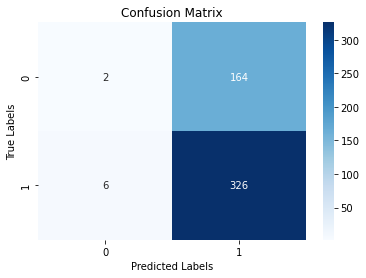

In [66]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt


cm = confusion_matrix(labels.reshape(-1,1), predictions2.reshape(-1,1))


plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')


plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')


plt.show()
